In [3]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots


In [4]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=2)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
size_py_small = 0.393701*[20, 10]     # figure size

res = 300                       # figure resolution (dpi)

300

In [5]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [6]:
save_figs = false
num_passes = true
out_path = joinpath(pwd(), "..", "..", "thesis")


"\\\\win.desy.de\\home\\muelderk\\My Documents\\MPC\\MPC_sim_Luna\\..\\..\\thesis"

## READ IN LOW GDD MIRROR DATA

In [7]:
using DelimitedFiles

## READ IN LOW GDD MIRROR DATA
file_low_GDD_mir = joinpath("input", "mirrordata_0fs2.txt")
file_high_GDD_mir = joinpath("input", "mirrordata_-30fs2.txt")

data, header = readdlm(file_low_GDD_mir, '\t', header=true)

wl_low = data[:,1]
R_low = data[:,2]
GDD_low = data[:,3]


data, header = readdlm(file_high_GDD_mir, '\t', header=true)

wl_high = data[:,1]
R_high = data[:,2]
GDD_high = data[:,3]

251-element Vector{Float64}:
    274.602
    440.228
    633.096
    675.624
    288.78
   -409.266
   -796.979
   -692.267
   -414.619
   -191.07
      ⋮
  -1582.87
  -1927.75
  -2446.49
  -3360.49
  -5263.92
  -9981.52
 -24309.7
 -76885.0
 -98453.1

## I) Read data from .h5 file

In [8]:
run = "run_2025_06_04__00_44_43"
run_path = joinpath("output_thesis", run)

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [9]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.20 - 0.50 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 4496.89, samples: 8192, δt = 333.56 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 1500.0 fs, actual time window: 2732.6 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 4096 / 8192, ωmax 4.71e+15 / 9.42e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

In [10]:
println(params["gas"])

Kr


## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [11]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

2049-element Vector{ComplexF64}:
  -1.611306710017584e-8 + 0.0im
   3.875790073753562e-8 + 8.25080209757794e-8im
  1.5313475599574683e-8 - 7.104910531138427e-8im
  -9.561454594656826e-8 - 1.1656435158305729e-7im
 -4.4472857853755055e-8 - 3.432060769201581e-8im
 -4.9644687846245844e-8 + 2.2425713409773307e-7im
   3.495245208353227e-8 - 3.654704187718479e-8im
  -8.920887458695846e-8 - 4.806772256186211e-8im
  -5.616218955325795e-8 + 1.7067336809743676e-7im
   -8.10549552666035e-8 - 2.587820649210366e-8im
                        ⋮
   5.519090612298172e-8 + 1.115924788368809e-7im
 -1.0617690055877463e-7 + 7.08018191884094e-10im
 -1.3388532450096257e-7 + 4.266724612723333e-8im
   -7.25003269581771e-8 - 6.398792545996259e-8im
   4.849013169617388e-8 + 1.0879204937313729e-7im
  1.3111441920773724e-7 - 7.346873869484567e-8im
   6.177534872145691e-8 - 3.951590432036138e-8im
   -2.38759733218343e-8 - 1.3102836944564879e-8im
 -1.5995864339721836e-7 + 1.0766221205957106e-7im

In [12]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

2049-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

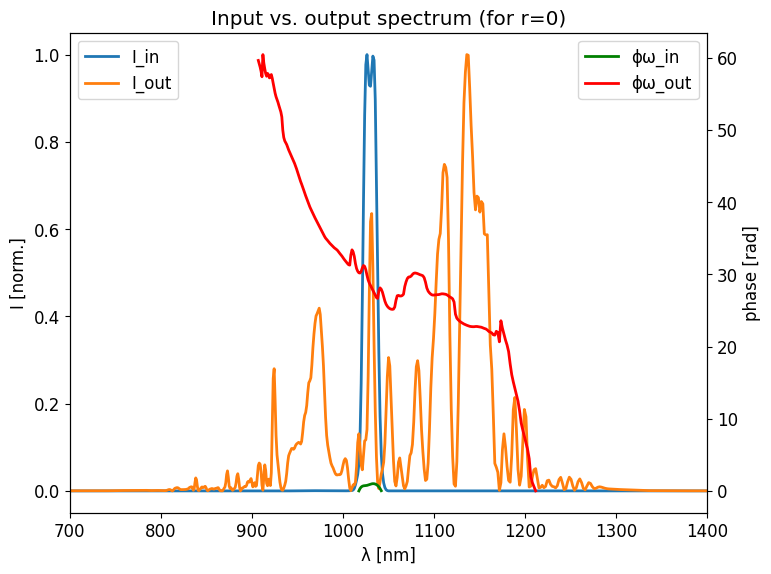

In [13]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("Input vs. output spectrum (for r=0)")
ax1.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_in)), label="I_in")
ax1.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(λ.*1e9, ϕω_in, label="ϕω_in", color="green")
ax2.plot(λ.*1e9, ϕω_out, label="ϕω_out", color="red")
ax1.set_xlim(700, 1400)
# ax1.set_xlim(λlims[1]*1e9, λlims[2]*1e9)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectrum_in_vs_out.png"), dpi=res) 
end
plt.gcf()

In [126]:
Eωr0_1 = Eωr0[:,end,5]
Eωr0_2 = Eωr0[:,1,6]


2049-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [128]:
# mirror data
path_m1 = joinpath("input", "mirror_R_100_GDD_0fs2.txt") #"mirror_R_100_GDD_0fs2_data.txt") #"mirror_R_data_GDD_0fs2.txt") # "mirrordata_0fs2.txt"; "mirror_R_100_GDD_0fs2.txt"

"input\\mirror_R_100_GDD_0fs2.txt"

In [129]:
# MIRROR 1
    data = readdlm(path_m1, skipstart=1)

    λ_m1 = data[:,1].*1e-9     # read in wavelengths [m]
    R_m1 = data[:,2].*1e-2     # read in reflectivity [fractions]
    GDD_m1 = data[:,3].*1e-30  # read in GDD [s^2]

    # for planck taper function
    windowwidth1 = 20e-9
    λ_min1 = minimum(λ_m1)+windowwidth1
    λ_max1 = maximum(λ_m1)-windowwidth1

    # add additional group delay if necessary
    delay1 = nothing #198.7e-15

In [ ]:
# window = Maths.planck_taper(λ, minimum(λ_m1), λ_min1, λ_max1, maximum(λ_m1))

2049-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

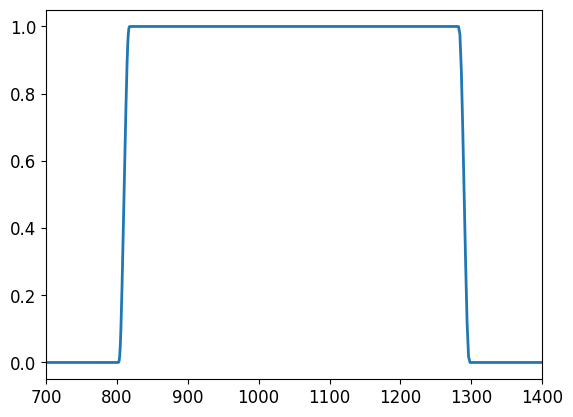

In [ ]:
# plt.figure()
# plt.plot(λ.*1e9, window)
# plt.xlim(700, 1400)
# plt.gcf()

In [130]:
function reflecting_mirror1(Eωr)
    Eωr_refl = copy(Eωr)

    print("Applying reflectivity and GDD data of mirror 1...")
    Fields.prop_mirror!(Eωr_refl, grid.ω, 1, λ_m1, R_m1, λ_m1, GDD_m1, λ0, λ_min1, λ_max1, windowwidth=windowwidth1) 
    
    if delay1 !== nothing
        # adding additional linear phase
        ω0 = PhysData.wlfreq(λ0)
        ϕ_delay = delay1 .* (grid.ω .- ω0)
        Eωr_refl .*= exp.(-1im*ϕ_delay)
    end
    return Eωr_refl

    println("done.")
end

reflecting_mirror1 (generic function with 1 method)

In [133]:
Eωr0_1_refl = reflecting_mirror1(Eωr0_1)

Applying reflectivity and GDD data of mirror 1...

2049-element Vector{ComplexF64}:
 -0.0 + 0.0im
  0.0 + 0.0im
 -0.0 + 0.0im
 -0.0 + 0.0im
  0.0 + 0.0im
 -0.0 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
  0.0 - 0.0im
      ⋮
  0.0 - 0.0im
  0.0 + 0.0im
  0.0 - 0.0im
  0.0 + 0.0im
 -0.0 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
 -0.0 + 0.0im

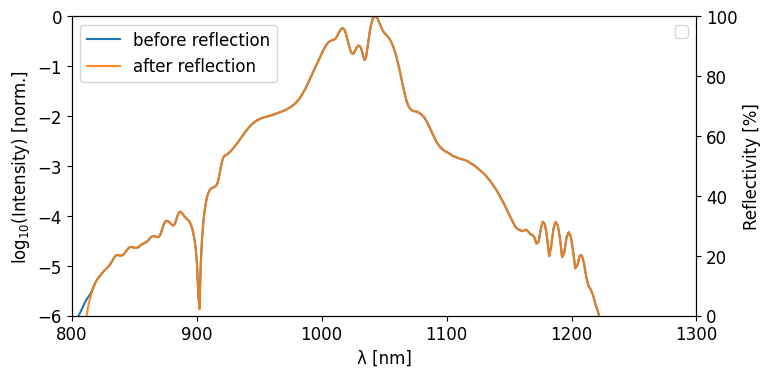

In [141]:
smallval = 1e-50

fig, ax1 = plt.subplots(figsize=size_py_small)
# ax1.set_title("Two passes compared")
ax1.plot(λ.*1e9, Maths.log10_norm(abs2.(Eωr0_1).+smallval), label="before reflection", linewidth=1.5)
# ax1.plot(λ.*1e9, Maths.log10_norm(abs2.(Eωr0_2).+smallval), label="after reflection", alpha=0.9, linewidth=1.5)
ax1.plot(λ.*1e9, Maths.log10_norm(abs2.(Eωr0_1_refl).+smallval), label="after reflection", alpha=0.9, linewidth=1.5)
ax2 = ax1.twinx()
# ax2.plot(wl_low, R_low, label="low GDD mirror", color="black", alpha=0.7, linestyle="dotted", linewidth=1.5)
# ax2.plot(λ.*1e9, ϕω_in, label="ϕω_in", color="green")
# ax2.plot(λ.*1e9, ϕω_out, label="ϕω_out", color="red")
ax1.set_xlim(800, 1300)
ax1.set_ylim(-6,0)
ax2.set_ylim(0,100)
# ax1.set_xlim(λlims[1]*1e9, λlims[2]*1e9)
ax1.set_xlabel("λ [nm]")
# ax1.set_ylabel("I [norm.]")
ax1.set_ylabel("log\$_{10}\$(Intensity) [norm.]")
ax2.set_ylabel("Reflectivity [%]")
# ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectrum_in_vs_out.png"), dpi=res) 
end
# plt.savefig(joinpath(out_path, "spectrum_before_after_refl.png"), dpi=res) 
plt.gcf()

### b) Input vs. output pulse

In [121]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

4096-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

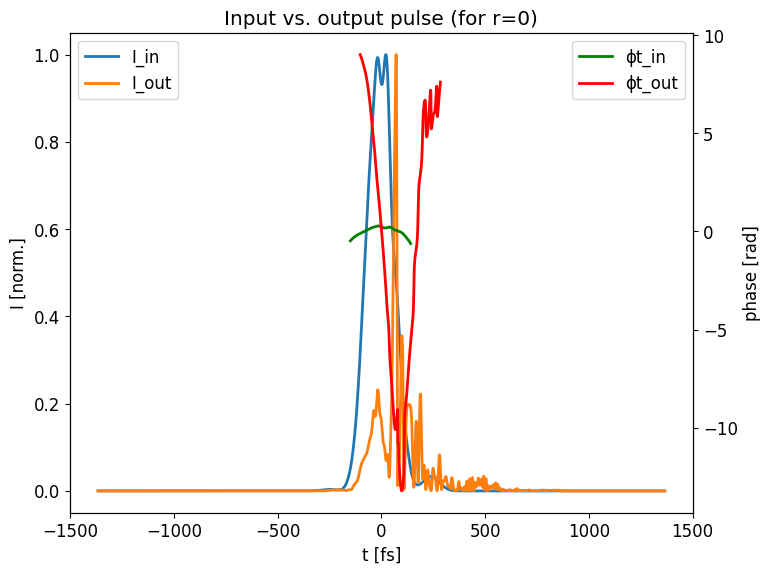

In [122]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_in)), label="I_in")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
# ax1.set_xlim(-200, 200)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end

plt.gcf()

In [135]:
Etr0_1 = Maths.hilbert(FFTW.irfft(Eωr0_1, length(t), 1))
Etr0_2 = Maths.hilbert(FFTW.irfft(Eωr0_2, length(t), 1))
Etr0_1_refl = Maths.hilbert(FFTW.irfft(Eωr0_1_refl, length(t), 1))


4096-element Vector{ComplexF64}:
 -103.37566584348679 - 53.85705840587616im
 -13.266579627990723 - 117.30001077055931im
   91.68269205093384 - 76.26106178760529im
  114.05088424682617 + 35.8209263086319im
  31.020188093185425 + 114.43542009592056im
  -78.00409725308418 + 86.27602863311768im
 -111.71989679336548 - 17.677183747291565im
  -45.88072097301483 - 99.48521721363068im
   54.48659873008728 - 91.34717333316803im
  103.89792013168335 - 7.49419778585434im
                     ⋮
   59.99771386384964 + 118.34041866660118im
  -67.01111948490143 + 114.36709415912628im
 -130.83487206697464 + 5.276732802391052im
  -73.85887372493744 - 104.54797059297562im
   45.14574643969536 - 115.7740752696991im
  117.46916204690933 - 26.76061949436553im
   86.73867582529783 + 79.18565684556961im
 -14.614548027515411 + 114.83407428860664im
 -102.19994926452637 + 53.97099810838699im

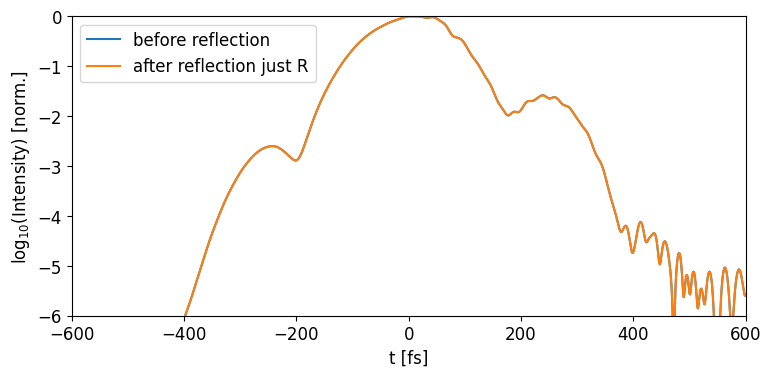

In [142]:
fig, ax1 = plt.subplots(figsize=size_py_small)
# ax1.set_title("Input vs. output pulse (for r=0)")
# ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_1)), label="I_in")
# ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_2)), label="I_out")
ax1.plot(t.*1e15, Maths.log10_norm(abs2.(Etr0_1)), label="before reflection", linewidth=1.5)
# ax1.plot(t.*1e15, Maths.log10_norm(abs2.(Etr0_2)), label="after reflection R+GDD", alpha=0.9, linewidth=1.5)
ax1.plot(t.*1e15, Maths.log10_norm(abs2.(Etr0_1_refl)), label="after reflection just R", linewidth=1.5)

# ax2 = ax1.twinx()
# ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
# ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
ax1.set_xlim(-600, 600)
ax1.set_ylim(-6,0)
ax1.set_xlabel("t [fs]")
# ax1.set_ylabel("I [norm.]")
ax1.set_ylabel("log\$_{10}\$(Intensity) [norm.]")
# ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end
#plt.savefig(joinpath(out_path, "pulse_before_after_refl.png"), dpi=res) 

plt.gcf()

### c) Spectral homogeinity across r

In [24]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

128×2049 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  22.9591      60.106     562.899      …  8.40588e6       4.28194e8
 0.0  21.3299      59.4657    530.868         7.1604e6        4.00519e8
 0.0  18.2087      50.5963    502.702         5.64865e6       3.68606e8
 0.0  14.224       37.201     474.839         4.86021e6       3.19574e8
 0.0  10.2891      25.9343    440.144         4.84194e6       2.55585e8
 0.0   6.66445     17.6487    405.023      …  4.6169e6        1.95929e8
 0.0   3.95014     11.5102    376.567         4.16172e6       1.42203e8
 0.0   2.44144      7.27919   354.414         4.03422e6       9.26367e7
 0.0   1.79871      4.77696   332.28          3.92619e6       5.22988e7
 0.0   1.71023      3.18294   304.432         3.29355e6       2.36474e7
 ⋮                                         ⋱             
 0.0   0.00928526  11.8065      0.744453      3.65944e6       1.76776e5
 0.0   0.0187388   10.6852      0.775261   …  4.3764e6        3.22243e5
 0.0   0.0270477   

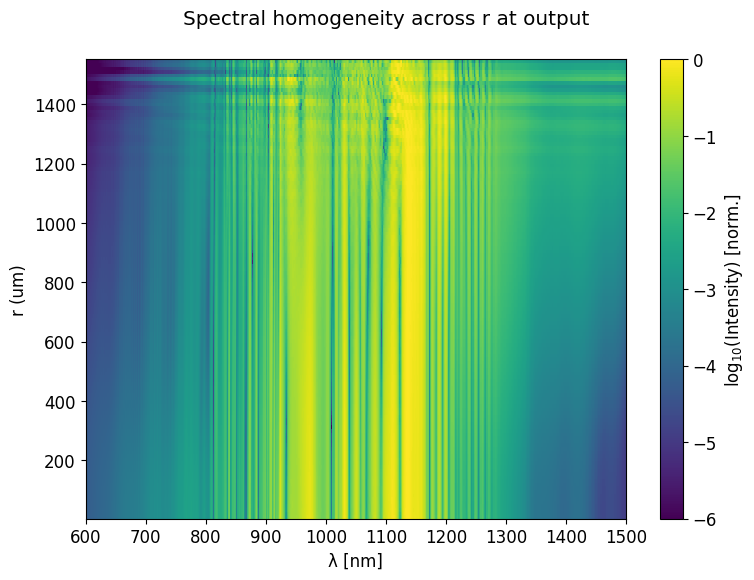

In [25]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log\$_{10}\$(Intensity) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [26]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

4096×128 Matrix{ComplexF64}:
  -0.0708196+0.132527im    …   0.000146019-0.000105754im
    -0.13773+0.048259im        0.000159249+8.33999e-6im
   -0.130313-0.0562919im       0.000112063+9.67612e-5im
  -0.0556653-0.126319im         2.37233e-5+0.000141364im
   0.0441407-0.126398im        -7.44002e-5+0.000115991im
    0.114527-0.0599773im   …  -0.000123979+3.23977e-5im
    0.119804+0.033015im       -0.000105521-5.24825e-5im
   0.0625677+0.101305im         -4.4682e-5-0.000102649im
   -0.021777+0.111792im         3.40985e-5-0.000104913im
  -0.0875933+0.0645981im        9.60068e-5-5.13336e-5im
            ⋮              ⋱  
 -0.00940645+0.19024im         0.000136603-0.000312464im
   -0.133195+0.130844im         0.00030695-0.000141118im
   -0.182855+0.00544975im      0.000317904+0.000105956im
   -0.134727-0.117847im    …   0.000148473+0.000291089im
  -0.0178564-0.173837im        -9.63017e-5+0.000294048im
    0.102659-0.135666im       -0.000253716+0.000129756im
    0.162682-0.0285578im      -0.

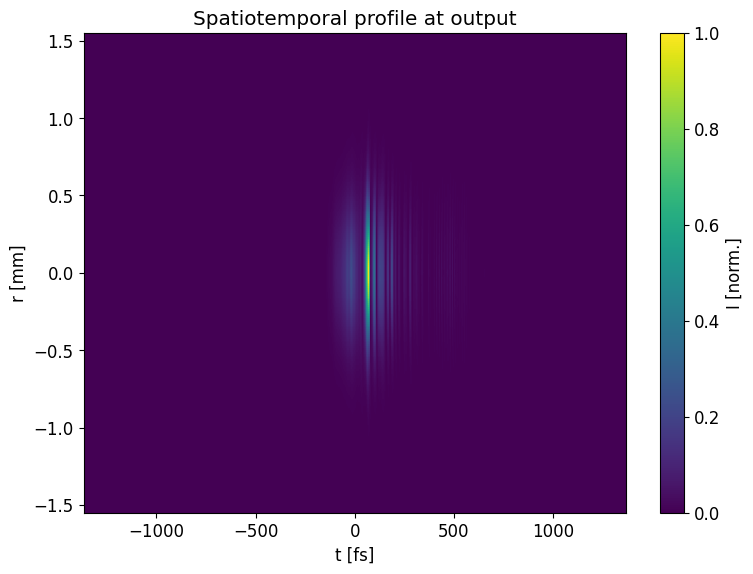

In [27]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [28]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

257

In [29]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

6030-element Vector{Float64}:
  0.0
  0.0019135454576426011
  0.0038270909152852022
  0.005740636372927804
  0.0076541818305704045
  0.009567727288213005
  0.011481272745855607
  0.013394818203498207
  0.015308363661140809
  0.01722190911878341
  ⋮
 11.465964382194466
 11.46787792765211
 11.469791473109751
 11.471705018567395
 11.473618564025037
 11.47553210948268
 11.477445654940322
 11.479359200397965
 11.481272745855607

In [30]:
println(L)

0.38270909152852023


### a) Beams Caustic 

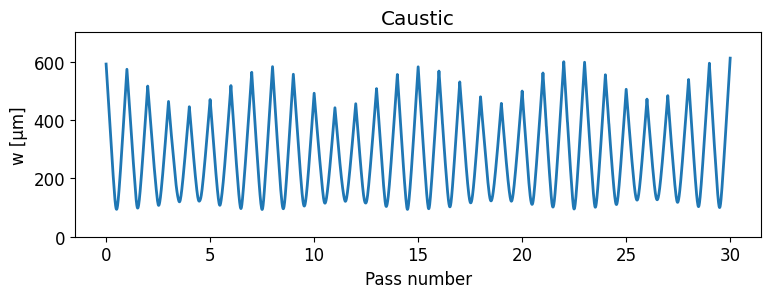

In [31]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
plt.title("Caustic")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
# plt.plot(z_total.*1e2, w_z.*1e6)
plt.plot(z_total./L, w_z.*1e6)
# plt.xlabel("z [cm]")
plt.xlabel("Pass number")
plt.ylabel("w [μm]")
# plt.xlim(28,31)
plt.ylim(0,700)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

### b) Minimum beam waist per pass

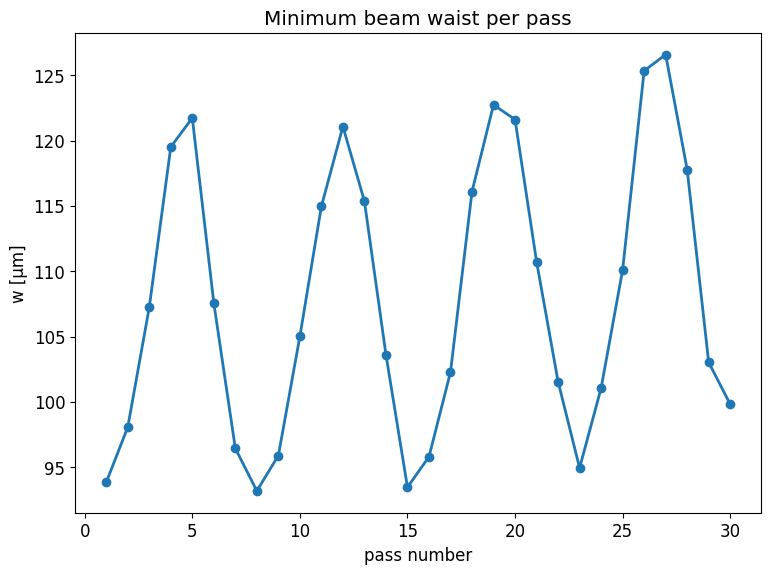

In [32]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

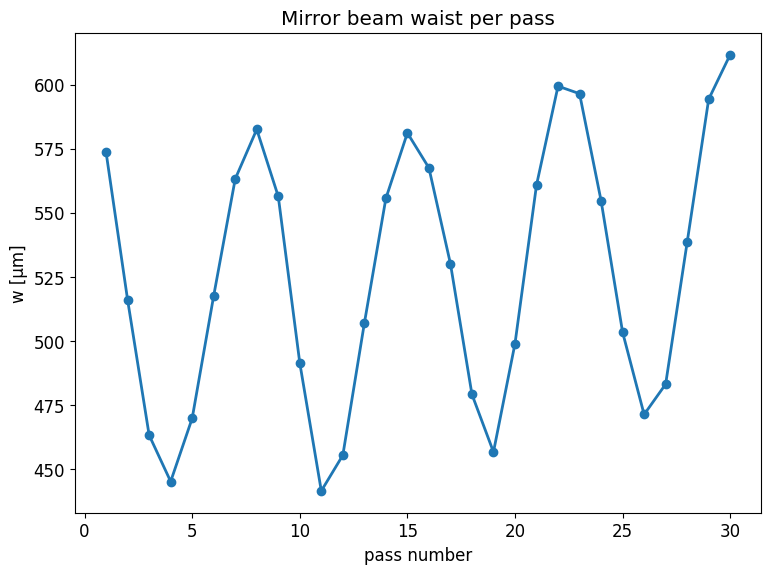

In [33]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [34]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)


2049×6030 Matrix{Float64}:
 0.0      0.0             0.0         …      0.0           0.0
 0.0  47458.9         22075.0               50.1447       23.3243
 0.0      1.30566e6       6.07313e5        127.507        59.3087
 0.0      6.73112e5       3.13091e5       1234.43        574.184
 0.0      1.0248e6        4.76675e5        304.69        141.723
 0.0      1.12699e6       5.24208e5   …   7958.81       3701.96
 0.0      3.17288e6       1.47583e6        555.561       258.413
 0.0      1.08154e6       5.03067e5       3036.34       1412.32
 0.0      1.60622e6       7.47115e5      12468.1        5799.39
 0.0      3.75531e6       1.74674e6       3538.64       1645.96
 ⋮                                    ⋱                 
 0.0      8.00836e9       3.725e9     …      3.89224e8     1.81043e8
 0.0      2.47318e11      1.15037e11         2.83402e8     1.31821e8
 0.0      1.12431e11      5.22961e10         4.96848e8     2.31103e8
 0.0      1.00112e11      4.65661e10         2.35516e8     1.09

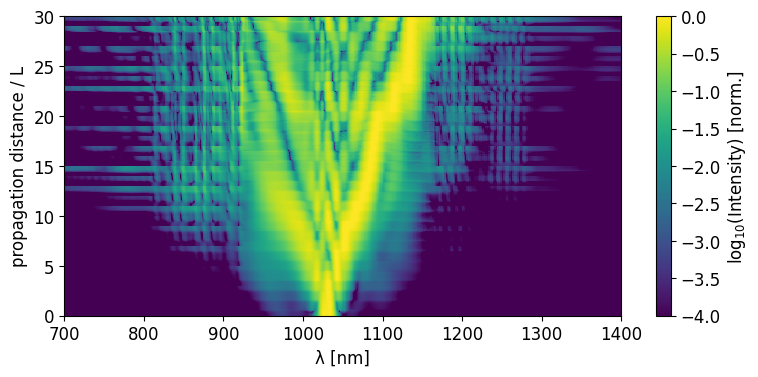

In [147]:
#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py_small)
# plt.suptitle("Spectral evolution at r=0")
# plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.pcolormesh(λ.*1e9, z_total./L, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-4, 0)    
plt.colorbar(label="log\$_{10}\$(Intensity) [norm.]")
# plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlim(700,1400)
# plt.ylim(3,10)
plt.xlabel("λ [nm]")
# plt.ylabel("z [cm]")
plt.ylabel("propagation distance / L")
# plt.xlim(800,1300)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl_log.png"), dpi=res) 
end
plt.savefig(joinpath(out_path, "spec_evol_lab3.png"), dpi=res) 
plt.gcf()


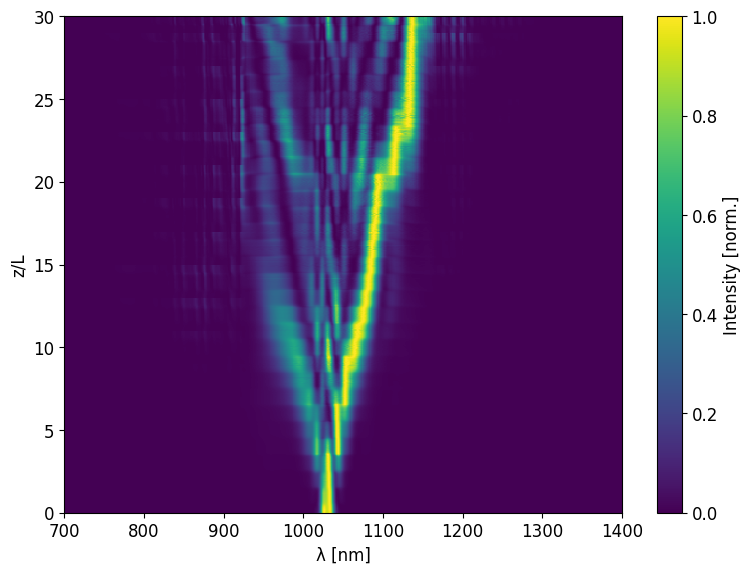

In [36]:
#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
# plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.normbymax(transpose(Iλr0_fused[:, :]),2))   
plt.pcolormesh(λ.*1e9, z_total./L, Maths.normbymax(transpose(Iλr0_fused[:, :]),2))   
plt.clim(0, 1)    
plt.colorbar(label="Intensity [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,10)
plt.xlabel("λ [nm]")
# plt.ylabel("z [cm]")
plt.ylabel("z/L")
plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()


In [37]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

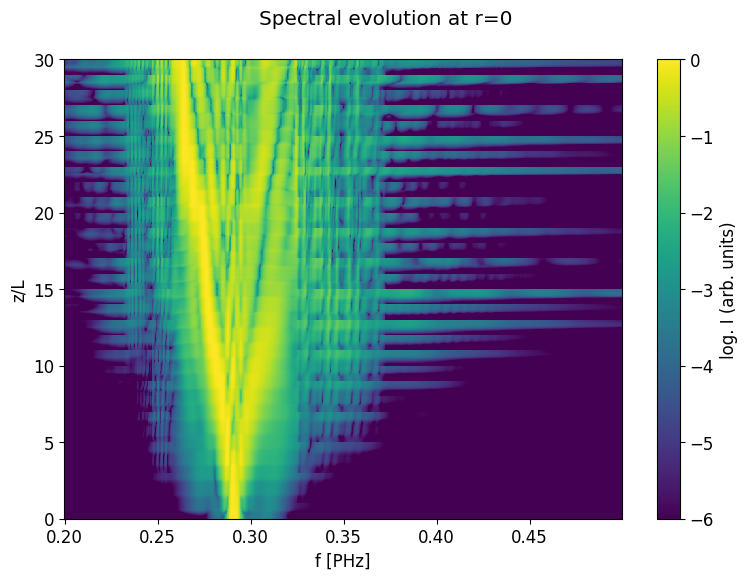

In [38]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
# plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.pcolormesh(f*1e-15, z_total./L, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
# plt.ylabel("z [cm]")
plt.ylabel("z/L")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [39]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

4096×6030 Matrix{Float64}:
 1.44486e7  1.05603e-9  2.4608e-8   …  0.00488721  0.153131   2.90142
 1.23903e7  1.04401e-9  2.44187e-8     0.0044638   0.144353   2.73938
 1.82071e7  1.02833e-9  2.41976e-8     0.00411035  0.135529   2.58254
 2.63409e7  1.02746e-9  2.40618e-8     0.00381967  0.126822   2.43024
 2.99292e7  1.02588e-9  2.40275e-8     0.00356523  0.118464   2.28189
 2.58588e7  1.04399e-9  2.3995e-8   …  0.00331449  0.110641   2.13747
 1.69004e7  1.04095e-9  2.40121e-8     0.00304809  0.103394   1.99766
 9.4769e6   1.03842e-9  2.40357e-8     0.00276805  0.0966312  1.86335
 8.81981e6  1.04212e-9  2.40586e-8     0.00248756  0.0902358  1.73516
 1.51148e7  1.05975e-9  2.41298e-8     0.0022155   0.0841525  1.61324
 ⋮                                  ⋱                         
 5.33109e7  1.23296e-9  2.85674e-8     0.00964384  0.236164   4.49394
 3.76243e7  1.21521e-9  2.79757e-8     0.00898136  0.226678   4.3173
 2.55205e7  1.18875e-9  2.75218e-8     0.00840266  0.216972   4.13884
 

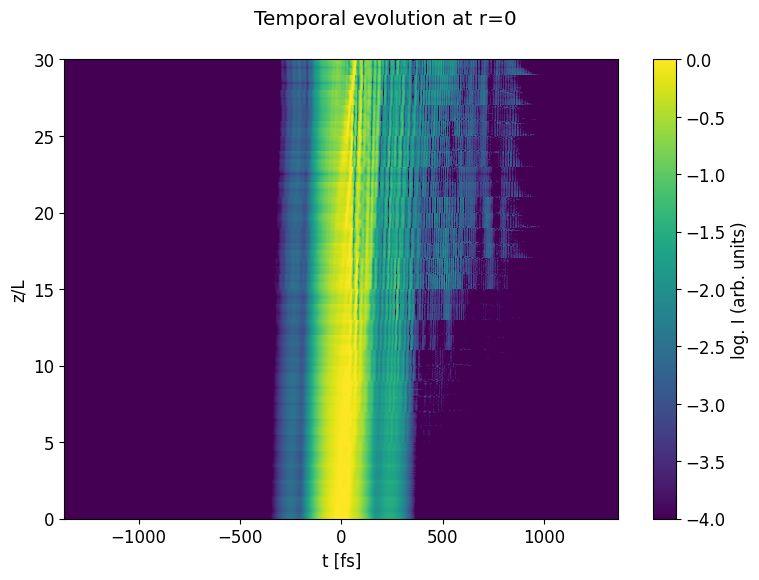

In [40]:
#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
# plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.pcolormesh(t.*1e15, z_total./L, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-4, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
# plt.ylabel("z [cm]")
plt.ylabel("z/L")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

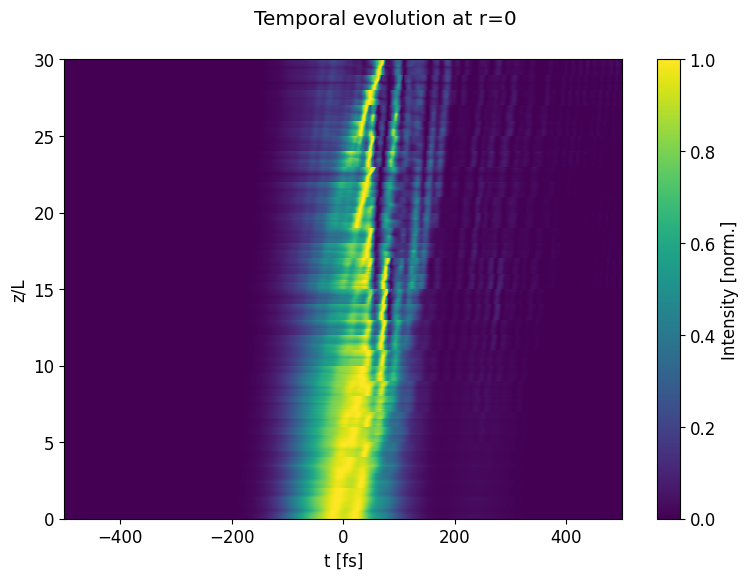

In [41]:
#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
# plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.normbymax(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.pcolormesh(t.*1e15, z_total./L, Maths.normbymax(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(0, 1)    
plt.colorbar(label="Intensity [norm.]")
# plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlim(-500,500)
plt.ylim(0,30)
plt.xlabel("t [fs]")
# plt.ylabel("z [cm]")
plt.ylabel("z/L")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [42]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [43]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [44]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×30 Matrix{Float64}:
 2.1304e18   2.32758e18  3.13365e18  …  4.7191e18   4.8761e18   3.64524e18
 2.17209e18  2.37001e18  3.18178e18     4.81092e18  4.96602e18  3.72922e18
 2.21504e18  2.41361e18  3.22981e18     4.90736e18  5.0577e18   3.80488e18
 2.25923e18  2.45838e18  3.28387e18     5.01083e18  5.15712e18  3.87013e18
 2.30478e18  2.50443e18  3.35041e18     5.11853e18  5.2701e18   3.93202e18
 2.35177e18  2.55177e18  3.42152e18  …  5.22724e18  5.39206e18  4.00647e18
 2.40021e18  2.60032e18  3.49129e18     5.33215e18  5.51489e18  4.10185e18
 2.45016e18  2.65036e18  3.54974e18     5.43858e18  5.62761e18  4.21097e18
 2.50154e18  2.7019e18   3.60481e18     5.54725e18  5.73302e18  4.31584e18
 2.55461e18  2.75493e18  3.66585e18     5.66822e18  5.84675e18  4.39604e18
 ⋮                                   ⋱                          
 2.75931e18  3.54834e18  4.60064e18     4.3956e18   3.96157e18  3.46466e18
 2.69957e18  3.4653e18   4.50006e18     4.29769e18  3.88628e18  3.3956e18
 2.64179e18 

In [45]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


6030-element Vector{Float64}:
 2.13039964150327e18
 2.1720928137304376e18
 2.2150368261246326e18
 2.259232036667962e18
 2.3047798246998072e18
 2.3517696903522365e18
 2.400212814574849e18
 2.450161177336933e18
 2.5015418763138785e18
 2.5546074748007173e18
 ⋮
 3.464656694932539e18
 3.395598252247513e18
 3.34040880394731e18
 3.2883122203183063e18
 3.2212985993901947e18
 3.13987296666657e18
 3.0508433092712525e18
 2.967494493793792e18
 2.903069074829466e18

In [46]:
size(z_total)

(6030,)

In [47]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

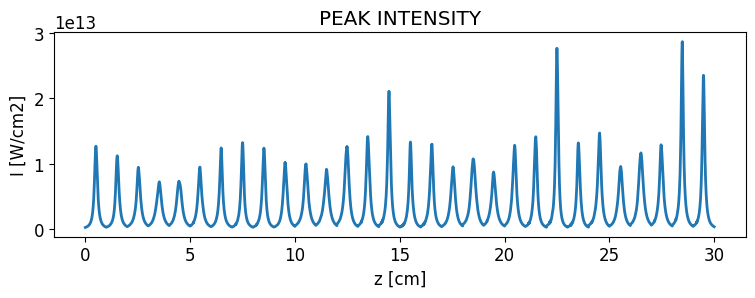

In [48]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
# plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.plot(z_total./L, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("I [W/cm2]")
# plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [49]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [50]:
println(n2)

UndefVarError: UndefVarError: `n2` not defined

In [51]:
λ0

1.03e-6

In [52]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

30-element Vector{Float64}:
 2.3069072604802896
 2.23351870402644
 2.2177522405066155
 2.0771217612768753
 2.198025700804905
 2.203968739437655
 2.3021443367215877
 2.3170142349268024
 2.3403373603989297
 2.289997950393678
 ⋮
 2.711202263467335
 4.27328488607385
 2.474694825207595
 3.103396656736377
 2.5053280264681765
 3.188994206707029
 2.9219116962729164
 4.400319988288889
 3.7487902987214206

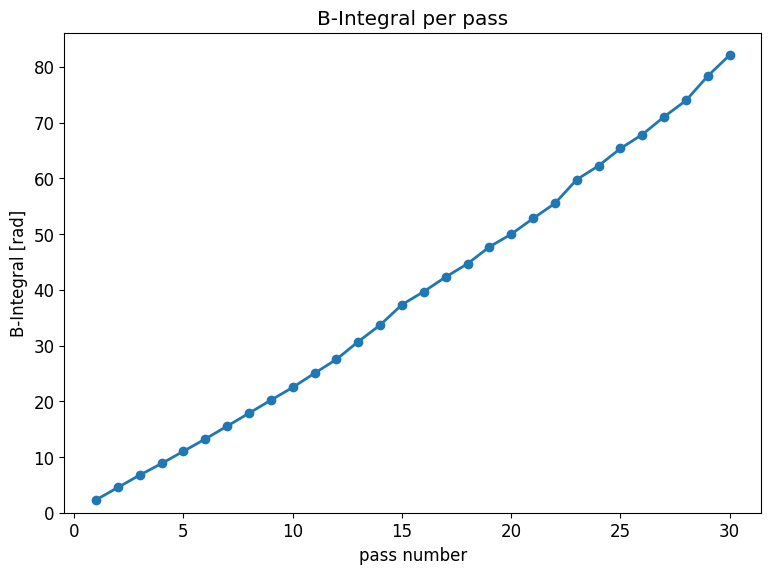

In [53]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

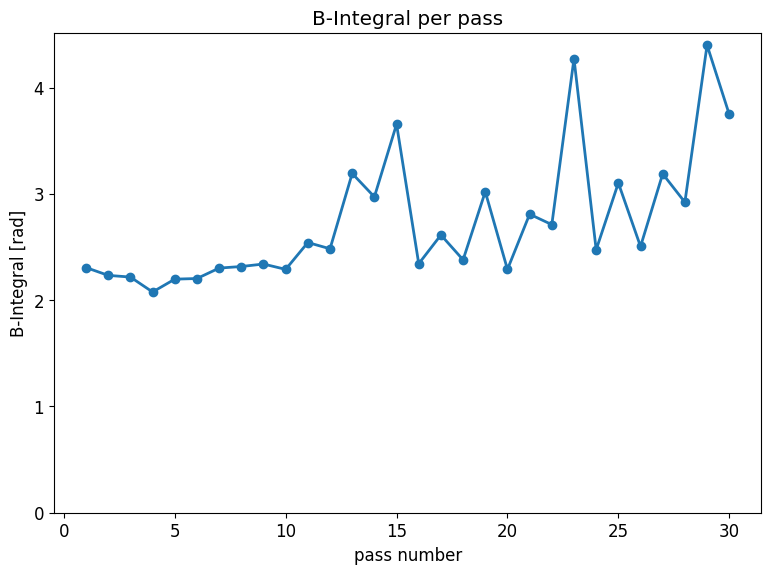

In [54]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [55]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 1.727957688315069
B_total = 25.919365324726034
